In [1]:
import os
import spacy
from spacy.lang.es.examples import sentences
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.sentiment import SentimentIntensityAnalyzer
from wordcloud import WordCloud
import nltk

#nltk.download('all')
  
import matplotlib.pyplot as plt
import os 

# cargar modelo de lenguaje de spacy para español
nlp = spacy.load("es_core_news_sm")


discursos = []
data_dir = "../data/mananeras/"  # ruta relativa a la carpeta "src" hacia la carpeta "data/mananeras/"
for filename in ["m20190102.txt"]:
    with open(data_dir + filename, "r", encoding="utf-8") as f:
        discursos.append(f.read())

ModuleNotFoundError: No module named 'spacy'

In [2]:
len(discursos)

1

### Lematización y Tokenización

In [3]:
from nltk.stem import WordNetLemmatizer

# definir el lematizador para español
lemmatizer = WordNetLemmatizer()

# tokenizar y normalizar el texto
stop_words = set(stopwords.words('spanish'))

# agregar palabras específicas
stop_words.update(['mil', 'millones', 'año', '2'])

tokens_list = []
for discurso in discursos:
    doc = nlp(discurso)
    tokens = []
    for token in doc:
        if not token.is_punct and not token.is_stop:
            lemma = lemmatizer.lemmatize(token.text.lower(), pos='v')
            if lemma not in stop_words and not all(c.isspace() for c in lemma):
                tokens.append(lemma)
    tokens_list.append(tokens)

In [4]:
print(len(tokens))
print(len(tokens_list))
tokens[:20]

1538
1


['reiterar',
 'manifestación',
 'deseo',
 'años',
 'pienso',
 'optimista',
 'mencioné',
 'ayer',
 'condiciones',
 'inmejorables',
 'mejore',
 'economía',
 'país',
 'crecimiento',
 'economía',
 'generen',
 'empleos',
 'gente',
 'trabajo',
 'salarios']

## Analisis de Frecuencias

In [5]:
from nltk import FreqDist

# Calculando la frecuencia de las palabras
fdist = FreqDist(tokens)

# Imprimiendo las 10 palabras más comunes
print(fdist.most_common(20))

[('nacional', 22), ('guardia', 21), ('información', 15), ('derecho', 12), ('seguridad', 11), ('sistema', 11), ('gracias', 10), ('tiempo', 9), ('gobierno', 9), ('país', 8), ('convocatoria', 8), ('años', 7), ('ejército', 7), ('presidente', 7), ('ayer', 6), ('diálogo', 6), ('problema', 6), ('méxico', 6), ('tipo', 6), ('secretaría', 6)]


##Visualización con Altair

In [7]:
import pandas as pd

In [8]:
import altair as alt

# Obtener las 10 palabras más comunes
top_words = dict(fdist.most_common(20))

# Convertir las claves a una lista y crear un dataframe
df = pd.DataFrame({'Palabras': list(top_words.keys()), 'Frecuencia': list(top_words.values())})

# Crear la figura usando Altair
chart = alt.Chart(df).mark_bar(color='green').encode(
    x=alt.X('Frecuencia:Q', axis=alt.Axis(title='Frecuencia', labelFontSize=14)),
    y=alt.Y('Palabras:N', sort='-x', axis=alt.Axis(title='Palabras', labelFontSize=14)),
    tooltip=['Palabras', 'Frecuencia']
).properties(
    title={
        'text': ['Palabras más comunes en los discursos'],
        'fontSize': 16,
        'fontWeight': 'bold',
        'anchor': 'middle',
        'color': 'black'
    },
    width=600,
    height=400
)

# Mostrar la figura con la cuadrícula habilitada
chart.configure_axis(labelFontSize=12, grid=True).configure_title(fontSize=16, color='black')

alt.Chart(...)

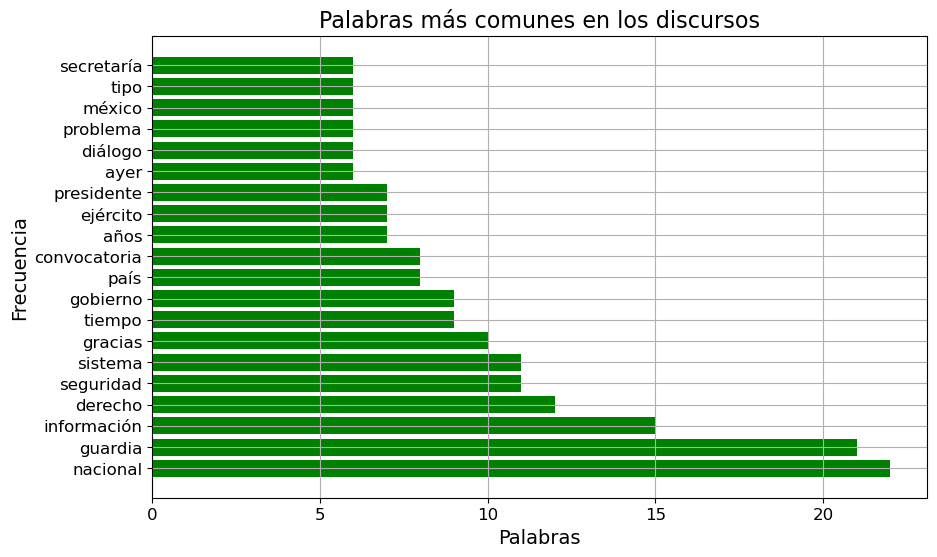

In [9]:
# Obtener las 10 palabras más comunes
top_words = dict(fdist.most_common(20))

# Convertir las claves a una lista
word_list = list(top_words.keys())

# Crear la figura
fig, ax = plt.subplots(figsize=(10, 6))

# Graficar las barras
ax.barh(word_list, top_words.values(), color='g')

# Personalizar la figura
ax.set_title('Palabras más comunes en los discursos', fontsize=16)
ax.set_xlabel('Palabras', fontsize=14)
ax.set_ylabel('Frecuencia', fontsize=14)
ax.tick_params(axis='both', which='major', labelsize=12)
ax.grid(True)

# Mostrar la figura
plt.show()

Es muy interesante el uso de la palabra "oiganlos", ya que eso implica que en multiples ocasiones el presidente hace referencias a porcentajes, es decir, a proporciones. Esa es una manera en que los receptores del discurso puedan darse una idea más clara de las proporciones que él manera

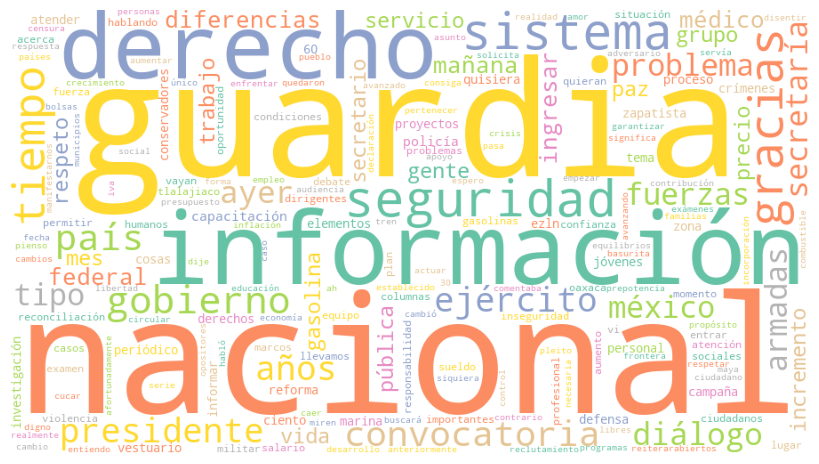

In [10]:
import random

# importando las paletas de colores
from palettable.colorbrewer.qualitative import Set2_8

# creando una lista de colores a partir de la paleta Set2
color_list = [tuple(rgb) for rgb in Set2_8.colors]

# Generando una wordcloud con la nueva paleta de colores
wordcloud = WordCloud(width=900, height=500, background_color='white', stopwords=stopwords,
                      min_font_size=10, colormap='Set2', color_func=lambda *args, **kwargs: color_list[random.randint(0, 7)]).generate_from_frequencies(fdist)

# Mostrando la imagen
plt.figure(figsize=(8, 8), facecolor=None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)

plt.show()

## Analisis de Sentimiento

In [11]:
from textblob import TextBlob

sentimientos = []
for tokens in tokens_list:
    discurso = " ".join(tokens)
    blob = TextBlob(discurso)
    polaridad = blob.sentiment.polarity
    subjetividad = blob.sentiment.subjectivity
    sentimientos.append({"polaridad": polaridad, "subjetividad": subjetividad})

In [12]:
for i, sentimiento in enumerate(sentimientos):
    print(f"Discurso {i+1}: Polaridad={sentimiento['polaridad']}, Subjetividad={sentimiento['subjetividad']}")

Discurso 1: Polaridad=0.024242424242424246, Subjetividad=0.2484848484848485


El resultado del análisis de sentimientos muestra que los cuatro discursos tienen puntajes de sentimiento negativos ya que los cuatro se encuentran muy cercanos al valor de -1

## Identificación de Temas Principales

In [13]:
# Importar librerías necesarias
from gensim import corpora, models
import numpy as np

# Crear una lista de diccionarios, donde cada diccionario representa un discurso
dict_list = []
for i, discurso in enumerate(discursos):
    dict_list.append({"id": i, "texto": ' '.join(tokens)})

# Crear un diccionario de términos a partir de los discursos
dictionary = corpora.Dictionary([doc["texto"].split() for doc in dict_list])

# Crear un corpus (lista de bolsas de palabras) a partir del diccionario
corpus = [dictionary.doc2bow(doc["texto"].split()) for doc in dict_list]

# Crear un modelo LDA con 5 tópicos
lda_model = models.ldamodel.LdaModel(corpus=corpus,
                                     id2word=dictionary,
                                     num_topics=5,
                                     passes=10,
                                     alpha='auto')

# Imprimir los tópicos más importantes para cada discurso
for doc in dict_list:
    bow = dictionary.doc2bow(doc["texto"].split())
    topics = lda_model[bow]
    top_topics = sorted(topics, key=lambda x: x[1], reverse=True)[:3]
    print(f"Discurso {doc['id'] + 1}: {', '.join([f'Tópico {topic[0]+1} ({round(topic[1]*100, 2)}%)' for topic in top_topics])}")

Discurso 1: Tópico 2 (99.9%)


Usamos la función print_topics() del modelo LDA entrenado, para mostrar las palabras más representativas de cada tópico, ordenados de mayor a menor importancia.

In [14]:
type(lda_model.show_topic(0))

list

In [15]:
# Define las listas
topic1 = lda_model.show_topic(0)
topic2 = lda_model.show_topic(1)
topic3 = lda_model.show_topic(2)
topic4 = lda_model.show_topic(3)

# Convierte cada lista en un dataframe de pandas
df_t1 = pd.DataFrame(topic1, columns=['token', 'score'])
df_t2 = pd.DataFrame(topic2, columns=['token', 'score'])
df_t3 = pd.DataFrame(topic3, columns=['token', 'score'])
df_t4 = pd.DataFrame(topic4, columns=['token', 'score'])

# Crea la visualización con Altair para cada dataframe
chart_t1 = alt.Chart(df_t1).mark_bar().encode(
    x='score',
    y="token"
).properties(title="Topic 1", width=400, height=300)

chart_t2 = alt.Chart(df_t2).mark_bar().encode(
    x='score',
    y="token"
).properties(title="Topic 2", width=400, height=300)

chart_t3 = alt.Chart(df_t3).mark_bar().encode(
    x='score',
    y="token"
).properties(title="Topic 3", width=400, height=300)

chart_t4 = alt.Chart(df_t4).mark_bar().encode(
    x='score',
    y="token"
).properties(title="Topic 4", width=400, height=300)

# Muestra las visualizaciones
chart_t1 | chart_t2

alt.HConcatChart(...)

In [63]:
chart_t3 | chart_t4

alt.HConcatChart(...)

In [16]:
import pandas as pd

num_topics=5 
num_words=15
# Creamos una lista con los datos de cada tópico
topicos = []
for idx, topic in lda_model.show_topics(formatted=False, num_topics=num_topics, num_words=num_words):
    topicos.append([f"Tópico {idx+1}", ", ".join([word[0] for word in topic])])

# Creamos el dataframe con los datos de los tópicos y las palabras más importantes
df_topicos = pd.DataFrame(topicos, columns=["Tópico", "Palabras más importantes"])

# Imprimimos el dataframe
print(df_topicos)

     Tópico                           Palabras más importantes
0  Tópico 1  guardia, nacional, información, derecho, siste...
1  Tópico 2  nacional, guardia, información, derecho, siste...
2  Tópico 3  nacional, guardia, información, derecho, graci...
3  Tópico 4  guardia, nacional, información, sistema, graci...
4  Tópico 5  nacional, guardia, información, derecho, segur...
